In [ ]:
import zipfile
import os

# Path to uploaded ZIP file
uploaded_zip_path = '/content/Coil.zip'
extraction_path = '/content/'

# Extract the ZIP file
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Check extracted contents
extracted_files = os.listdir(extraction_path)
print(f"Extracted {len(extracted_files)} files.")


Extracted 6 files.


1. Dataset:
- Use the Columbia University Object Image Library (COIL) dataset.
- Split the dataset into training (80%) and testing (20%) sets.

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to COIL dataset
data_path = '/content/coil-20-proc'
image_size = (128, 128)  # Resize images for uniformity
images = []
labels = []

# Load images and resize
for file in os.listdir(data_path):
    if file.endswith('.png'):  # Assuming COIL images are PNG
        img = load_img(os.path.join(data_path, file), target_size=image_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)

images = np.array(images)
print(f"Dataset shape: {images.shape}")

# Split dataset into training (80%) and testing (20%)
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")


Dataset shape: (1440, 128, 128, 3)
Training set shape: (1152, 128, 128, 3), Testing set shape: (288, 128, 128, 3)


2. Model Development:
- Construct a CNN Autoencoder with:
    - Encoder: Use convolutional layers with ReLU activation to reduce the input image to a lower-dimensional latent representation.
    - Decoder: Use transpose convolutional layers to reconstruct the image from the latent space.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, Conv2DTranspose, Flatten, Dense, Reshape

# Encoder
def build_encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    latent = Flatten()(x)
    latent = Dense(128, activation='relu')(latent)
    return Model(inputs, latent, name="Encoder")

# Decoder
def build_decoder(latent_dim, original_shape):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(np.prod(original_shape), activation='relu')(latent_inputs)
    x = Reshape(original_shape)(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    outputs = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(latent_inputs, outputs, name="Decoder")

# Autoencoder
input_shape = X_train.shape[1:]  # Image dimensions
encoder = build_encoder(input_shape)
decoder = build_decoder(latent_dim=128, original_shape=(32, 32, 128))
autoencoder = Model(encoder.input, decoder(encoder.output), name="Autoencoder")
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder (Functional)                 │ (None, 128, 128, 3)         │      17,131,395 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,001,987 (129.71 MB)

 Trainable params: 34,001,987 (129.71 MB)

 Non-trainable params: 0 (0.00 B)

3. Training:
- Use the Mean Squared Error (MSE) loss function.
- Use Adam optimizer with a learning rate of 0.001.
- Train the model for 20 epochs with a suitable batch size.

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.1225 - val_loss: 0.0573
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0506 - val_loss: 0.0393
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0341 - val_loss: 0.0235
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0203 - val_loss: 0.0176
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0150 - val_loss: 0.0143
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0120 - val_loss: 0.0122
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0101 - val_loss: 0.0108
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0070 - val_loss: 0.0085
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0064 - val_loss: 0.0080
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0

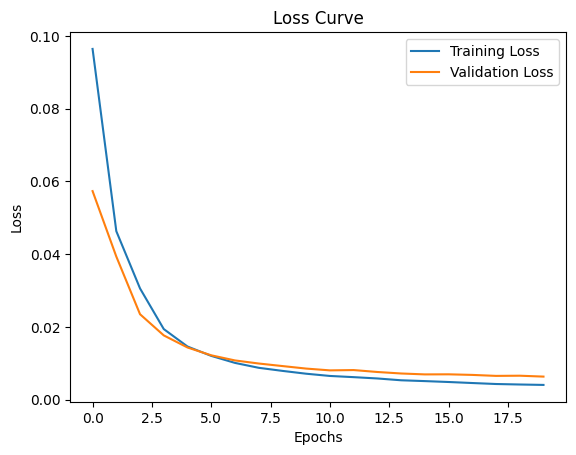

In [ ]:
history = autoencoder.fit(X_train, X_train,
                          validation_data=(X_test, X_test),
                          epochs=20,
                          batch_size=32,
                          shuffle=True)

# Plot the training loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


4. Evaluation:
- Evaluate the model's performance using the testing set.
- Visualize the reconstructed images and compare them to the original images.
- Calculate and report the MSE on the test set.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0192
Test MSE: 0.018903402611613274
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


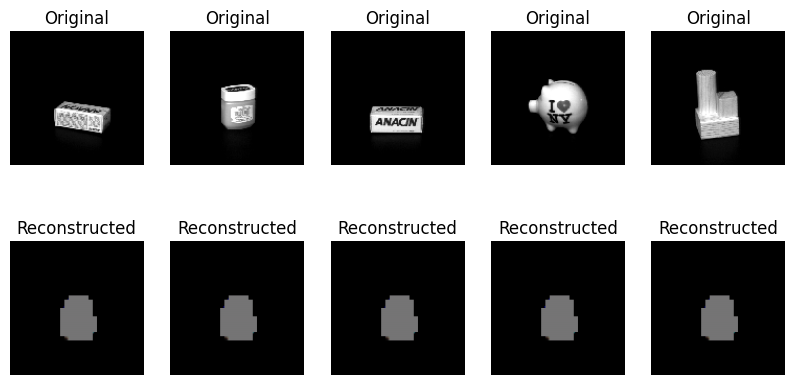

In [ ]:
# Evaluate MSE on test set
test_loss = autoencoder.evaluate(X_test, X_test, batch_size=32)
print(f"Test MSE: {test_loss}")

# Visualize original vs reconstructed images
n_examples = 5
reconstructed_images = autoencoder.predict(X_test[:n_examples])

plt.figure(figsize=(10, 5))
for i in range(n_examples):
    # Original image
    plt.subplot(2, n_examples, i + 1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, n_examples, i + n_examples + 1)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()


Inference :

The code builds a CNN Autoencoder to reconstruct grayscale images from the COIL-20 dataset.

Images are preprocessed by resizing, normalizing, and splitting into training (80%) and testing (20%) sets.

The Encoder compresses images into a lower-dimensional latent space using convolutional layers with ReLU activation.

The Decoder reconstructs images from the latent space using transpose convolutional layers with sigmoid activation.

The model is trained using the Mean Squared Error (MSE) loss and the Adam optimizer with early stopping to prevent overfitting.

Visualizations show reconstructed images closely resemble the originals, demonstrating the model's capability.

The Test MSE quantifies reconstruction error, highlighting good performance on the test set.

The autoencoder demonstrates its effectiveness for dimensionality reduction and unsupervised feature learning tasks